In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
import umap

In [7]:
data = pd.read_csv('../data/data.csv')

data = data[data['gene_type'] == 'protein_coding']
data

,gene_id,gene_name,gene_type,BC01_Pooled,BC01_Tumor,BC02_Pooled,BC03_Pooled,BC03LN_Pooled,BC04_Pooled,BC05_Pooled,...,BC11_04,BC11_07,BC11_28,BC11_43,BC11_56,BC11_69,BC11_70,BC11_78,BC11_81,BC11_88
0,ENSG00000000003.10,TSPAN6,protein_coding,2.33,1.25,43.96,7.64,9.32,133.37,84.77,...,0.00,47.44,16.11,0.00,6.56,0.00,0.00,0.00,200.82,0.00
1,ENSG00000000005.5,TNMD,protein_coding,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,ENSG00000000419.8,DPM1,protein_coding,60.70,28.44,74.73,41.41,87.69,120.41,70.67,...,198.96,0.00,0.00,20.63,0.00,0.00,0.00,136.07,22.03,204.58
3,ENSG00000000457.9,SCYL3,protein_coding,47.93,4.43,9.89,7.61,7.32,12.42,12.02,...,0.00,10.96,0.00,0.00,0.00,0.27,0.00,0.07,0.19,9.52
4,ENSG00000000460.12,C1orf112,protein_coding,4.79,1.67,10.87,0.92,15.13,17.10,5.69,...,0.00,6.97,9.02,0.00,0.00,0.14,247.69,22.60,11.35,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57788,ENSGR0000196433.7,ASMT,protein_coding,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57789,ENSGR0000197976.6,AKAP17A,protein_coding,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57790,ENSGR0000198223.10,CSF2RA,protein_coding,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57791,ENSGR0000205755.6,CRLF2,protein_coding,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [9]:

def pca(data):
    '''PCA'''
    # Separate gene ID and gene name columns
    gene_info = data[['gene_id', 'gene_name', 'gene_type']]
    # Select only the expression data columns for PCA
    expression_data = data.drop(['gene_id', 'gene_name', 'gene_type'], axis=1)

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(expression_data)

    # Apply PCA
    pca = PCA(n_components=2)  # You can change the number of components as needed
    principal_components = pca.fit_transform(scaled_data)

def tsne(data):
    selected_columns = data.iloc[:, 3:]  

    tsne = TSNE(n_components=2, perplexity=30)  # Adjust parameters as needed

    # Perform t-SNE
    tsne_result = tsne.fit_transform(selected_columns)

def Umap(data):
    selected_columns = data.iloc[:, 3:]  
    umap_reducer = umap.UMAP(n_components=2)  

    umap_result = umap_reducer.fit_transform(selected_columns)

def ica(data):
    gene_expression = data.iloc[:, 3:]  
    ica = FastICA(n_components=2, random_state=42)


    ica.fit(gene_expression)

    independent_components = ica.transform(gene_expression)

def vae(data):
    expression_data = data.iloc[:, 3:].values


    expression_data = (expression_data - np.min(expression_data)) / (np.max(expression_data) - np.min(expression_data))

    latent_dim = 2 

    encoder_inputs = keras.Input(shape=(expression_data.shape[1],))
    x = keras.layers.Dense(256, activation='relu')(encoder_inputs)
    x = keras.layers.Dense(128, activation='relu')(x)
    z_mean = keras.layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = keras.layers.Dense(latent_dim, name='z_log_var')(x)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    decoder_inputs = keras.layers.Dense(128, activation='relu')(z)
    decoder_outputs = keras.layers.Dense(expression_data.shape[1], activation='sigmoid')(decoder_inputs)

    vae = keras.Model(encoder_inputs, decoder_outputs)

    reconstruction_loss = tf.keras.losses.mean_squared_error(encoder_inputs, decoder_outputs)
    reconstruction_loss *= expression_data.shape[1]
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_mean(kl_loss)
    kl_loss *= -0.5
    vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    vae.fit(expression_data, epochs=50, batch_size=32)

    encoder = keras.Model(encoder_inputs, z_mean)
    encoded_data = encoder.predict(expression_data)


def find_time(model,execution_times,size):
    # Measure execution time for the algorithm with the current input size
    sample = data.sample(n=size)
    start_time = time.time()
    if model == 'umap':
        Umap(sample)
    elif model == 'pca':
        pca(sample)
    elif model == 'tsne':
        tsne(sample)  # Call your algorithm with the generated data
    elif model == 'ica':
        ica(sample)
    elif model == 'vae':
        vae(sample)
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Store execution time and corresponding dataset size
    execution_times.append(execution_time)

# Define the range of dataset sizes to test
data_sizes = [250,500,1000,2000,5000,10000,20000]  # Example sizes, adjust as needed

# Lists to store computation times and corresponding dataset sizes
pca_execution_times = []
tsne_execution_times = []
umap_execution_times = []
vae_execution_times = []
ica_execution_times = []
input_sizes = []

for size in data_sizes:
    find_time('vae',vae_execution_times,size)
    find_time('ica',ica_execution_times,size)
    find_time('pca',pca_execution_times,size)
    find_time('tsne',tsne_execution_times,size)
    find_time('umap',umap_execution_times,size)
    input_sizes.append(size)




Epoch 1/50
8/8 [==============================] - 2s 7ms/step - loss: 134.4440
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - loss: 121.1186
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 132.1991
Epoch 4/50
8/8 [==============================] - 0s 5ms/step - loss: 88.5857
Epoch 5/50
8/8 [==============================] - 0s 5ms/step - loss: 67.0562
Epoch 6/50
8/8 [==============================] - 0s 5ms/step - loss: 53.4945
Epoch 7/50
8/8 [==============================] - 0s 5ms/step - loss: 22.5536
Epoch 8/50
8/8 [==============================] - 0s 5ms/step - loss: 13.2862
Epoch 9/50
8/8 [==============================] - 0s 5ms/step - loss: 8.1682
Epoch 10/50
8/8 [==============================] - 0s 5ms/step - loss: 5.2737
Epoch 11/50
8/8 [==============================] - 0s 5ms/step - loss: 5.1632
Epoch 12/50
8/8 [==============================] - 0s 5ms/step - loss: 4.5321
Epoch 13/50
8/8 [==============================] - 0s 5ms/st

d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Epoch 1/50
16/16 [==============================] - 1s 5ms/step - loss: 128.6931
Epoch 2/50
16/16 [==============================] - 0s 5ms/step - loss: 111.1271
Epoch 3/50
16/16 [==============================] - 0s 5ms/step - loss: 59.3681
Epoch 4/50
16/16 [==============================] - 0s 5ms/step - loss: 24.4650
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 8.5387
Epoch 6/50
16/16 [==============================] - 0s 6ms/step - loss: 5.8484
Epoch 7/50
16/16 [==============================] - 0s 6ms/step - loss: 4.9230
Epoch 8/50
16/16 [==============================] - 0s 5ms/step - loss: 4.3212
Epoch 9/50
16/16 [==============================] - 0s 5ms/step - loss: 3.3050
Epoch 10/50
16/16 [==============================] - 0s 5ms/step - loss: 3.0274
Epoch 11/50
16/16 [==============================] - 0s 6ms/step - loss: 2.7665
Epoch 12/50
16/16 [==============================] - 0s 5ms/step - loss: 2.5683
Epoch 13/50
16/16 [========================

d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Epoch 1/50
32/32 [==============================] - 2s 7ms/step - loss: 114.2667
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 1266.3961
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 9.2876
Epoch 4/50
32/32 [==============================] - 0s 5ms/step - loss: 5.1948
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 3.8989
Epoch 6/50
32/32 [==============================] - 0s 6ms/step - loss: 2.5261
Epoch 7/50
32/32 [==============================] - 0s 6ms/step - loss: 2.0871
Epoch 8/50
32/32 [==============================] - 0s 6ms/step - loss: 1.8574
Epoch 9/50
32/32 [==============================] - 0s 5ms/step - loss: 1.6701
Epoch 10/50
32/32 [==============================] - 0s 5ms/step - loss: 1.5458
Epoch 11/50
32/32 [==============================] - 0s 5ms/step - loss: 1.4079
Epoch 12/50
32/32 [==============================] - 0s 6ms/step - loss: 1.3219
Epoch 13/50
32/32 [=========================

d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Epoch 1/50
63/63 [==============================] - 2s 5ms/step - loss: 3065.4246
Epoch 2/50
63/63 [==============================] - 0s 5ms/step - loss: 6.3390
Epoch 3/50
63/63 [==============================] - 0s 5ms/step - loss: 3.0189
Epoch 4/50
63/63 [==============================] - 0s 5ms/step - loss: 2.1912
Epoch 5/50
63/63 [==============================] - 0s 5ms/step - loss: 1.8791
Epoch 6/50
63/63 [==============================] - 0s 5ms/step - loss: 1.6594
Epoch 7/50
63/63 [==============================] - 0s 5ms/step - loss: 1.5112
Epoch 8/50
63/63 [==============================] - 0s 5ms/step - loss: 1.4491
Epoch 9/50
63/63 [==============================] - 0s 5ms/step - loss: 1.2954
Epoch 10/50
63/63 [==============================] - 0s 5ms/step - loss: 1.2065
Epoch 11/50
63/63 [==============================] - 0s 5ms/step - loss: 1.1313
Epoch 12/50
63/63 [==============================] - 0s 5ms/step - loss: 1.0214
Epoch 13/50
63/63 [===========================

d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Epoch 1/50
157/157 [==============================] - 2s 5ms/step - loss: 25894586417152.0000
Epoch 2/50
157/157 [==============================] - 1s 5ms/step - loss: 2.0265
Epoch 3/50
157/157 [==============================] - 1s 4ms/step - loss: 1.3656
Epoch 4/50
157/157 [==============================] - 1s 5ms/step - loss: 1.0635
Epoch 5/50
157/157 [==============================] - 1s 5ms/step - loss: 0.9022
Epoch 6/50
157/157 [==============================] - 1s 5ms/step - loss: 0.7680
Epoch 7/50
157/157 [==============================] - 1s 6ms/step - loss: 0.6601
Epoch 8/50
157/157 [==============================] - 1s 5ms/step - loss: 0.6065
Epoch 9/50
157/157 [==============================] - 1s 5ms/step - loss: 0.5328
Epoch 10/50
157/157 [==============================] - 1s 5ms/step - loss: 0.4875
Epoch 11/50
157/157 [==============================] - 1s 5ms/step - loss: 0.4022
Epoch 12/50
157/157 [==============================] - 1s 5ms/step - loss: 0.3161
Epoch 13/50


d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Epoch 1/50
313/313 [==============================] - 3s 5ms/step - loss: 32.7976
Epoch 2/50
313/313 [==============================] - 2s 5ms/step - loss: 0.7997
Epoch 3/50
313/313 [==============================] - 2s 5ms/step - loss: 0.5189
Epoch 4/50
313/313 [==============================] - 1s 5ms/step - loss: 0.2590
Epoch 5/50
313/313 [==============================] - 2s 5ms/step - loss: 0.0643
Epoch 6/50
313/313 [==============================] - 1s 5ms/step - loss: 0.0332
Epoch 7/50
313/313 [==============================] - 2s 5ms/step - loss: 0.0230
Epoch 8/50
313/313 [==============================] - 2s 5ms/step - loss: 0.0185
Epoch 9/50
313/313 [==============================] - 2s 5ms/step - loss: 0.0158
Epoch 10/50
313/313 [==============================] - 2s 5ms/step - loss: 0.0141
Epoch 11/50
313/313 [==============================] - 2s 5ms/step - loss: 0.0129
Epoch 12/50
313/313 [==============================] - 2s 5ms/step - loss: 0.0121
Epoch 13/50
313/313 [===

d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Epoch 1/50
625/625 [==============================] - 4s 5ms/step - loss: 61821348.0000
Epoch 2/50
625/625 [==============================] - 3s 5ms/step - loss: 0.6108
Epoch 3/50
625/625 [==============================] - 3s 5ms/step - loss: 0.2261
Epoch 4/50
625/625 [==============================] - 3s 5ms/step - loss: 0.0176
Epoch 5/50
625/625 [==============================] - 3s 5ms/step - loss: 0.0110
Epoch 6/50
625/625 [==============================] - 3s 5ms/step - loss: 0.0095
Epoch 7/50
625/625 [==============================] - 3s 5ms/step - loss: 0.0088
Epoch 8/50
625/625 [==============================] - 3s 5ms/step - loss: 0.0084
Epoch 9/50
625/625 [==============================] - 3s 5ms/step - loss: 0.0087
Epoch 10/50
625/625 [==============================] - 3s 5ms/step - loss: 0.0080
Epoch 11/50
625/625 [==============================] - 3s 5ms/step - loss: 0.0078
Epoch 12/50
625/625 [==============================] - 3s 5ms/step - loss: 0.0085
Epoch 13/50
625/62

d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


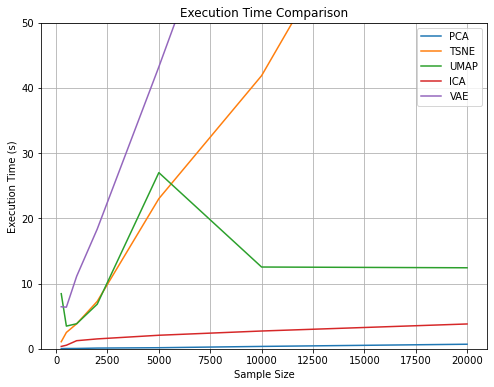

In [15]:
import pandas as pd
import time
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(input_sizes, pca_execution_times, label='PCA')
plt.plot(input_sizes, tsne_execution_times, label='TSNE')
plt.plot(input_sizes, umap_execution_times, label='UMAP')
plt.plot(input_sizes, ica_execution_times, label='ICA')
plt.plot(input_sizes, vae_execution_times, label='VAE')
plt.xlabel('Sample Size')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time Comparison')
plt.legend()
plt.grid(True)
plt.ylim(0,50)
plt.show()